In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Data Loading and Preprocessing

In [38]:
compas_df=pd.read_csv("C:\\Users\\tqy52\\Desktop\\Courses\\Applied Data Science\\Project4\\compas-scores-two-years.csv")

#Use the data of African American and Caucasian

races = ['African-American','Caucasian']

compas_df=compas_df[compas_df.race.isin(races)]

compas_df.head()

#use only specific columns for future prediction
compas_df_filtered = compas_df.loc[:, ['race']].join(compas_df.select_dtypes(include=['int64']))
#drop id and duplicate columns
compas_df_filtered = compas_df_filtered.drop(['id','decile_score.1', 'priors_count.1'], axis=1)




# Implemntaion of algorithms

In [39]:
#for the algorithms below, we apply on the whole dataset
X=compas_df_filtered
s=X.race
e=X.decile_score 
y=X.two_year_recid 




def PARTITION(X, e):
    unique_values = e.unique()  # find unique values of e
    groups = {}  # initialize empty dictionary to store resulting DataFrames
    
    for val in unique_values:
        group_df = X[e == val]  # filter rows in X where e equals current unique value
        groups[val] = group_df  # store resulting DataFrame in dictionary with key = unique value
        
    return groups  # return dictionary of resulting DataFrames







In [91]:
resulting_groups = PARTITION(X, e)
first_group_df = resulting_groups[1]
#print(first_group_df.head)

unique_values = (e.unique()) 
print(unique_values)

[ 3  4  8  6  1 10  5  9  2  7]


In [41]:

def delta(X, gender):
    # calculate the baseline probabilities
    p_pos_base = X.two_year_recid.mean()

    # calculate probabilities conditioned on gender
    p_pos_gender = X[X.race == gender].two_year_recid.mean()
    

    # calculate the number of gender people in X
    G = len(X[X.race == gender])

    # calculate delta
    
    delta_val = G * abs(p_pos_gender - p_pos_base)
    

    return int(delta_val)


In [42]:
for group in resulting_groups.values():
    print(delta(group,'Caucasian'))

11
10
3
1
5
4
3
1
1
2


In [43]:

#Algorithm 1: Local massaging
resulting_groups = PARTITION(X, e)
updated_groups_1 = []
for group in resulting_groups.values():
    males = group[group.race == 'Caucasian']
    females = group[group.race == 'African-American']
    
    # learn a ranker H for this group
    H = LogisticRegression(random_state=42,max_iter=500)
    H.fit(group.drop(['race','two_year_recid'], axis=1), group.two_year_recid)
    
    # rank and relabel males
    males_females = pd.concat([males,females])
    males_females['proba'] = H.predict_proba(males_females.drop(['two_year_recid','race'], axis=1))[:, 1]

   
    males_females = males_females.sort_values(by='proba')
    
    
    delta_males = int(delta(group, 'Caucasian'))
 
    males_to_relabel = males_females[(males_females['race'] == 'Caucasian') & (males_females['two_year_recid'] == 0) & (males_females['proba'] < 0.5)].head(delta_males)
    group.loc[males_to_relabel.index, 'two_year_recid'] = 1 - males_to_relabel.two_year_recid
    
    # rank and relabel females
    delta_females = int(delta(group, 'African-American'))
    females_to_relabel = males_females[(males_females['race'] == 'African-American') & (males_females['two_year_recid'] == 1) & (males_females['proba'] > 0.5)].head(delta_females)
    group.loc[females_to_relabel.index, 'two_year_recid'] = 1 - females_to_relabel.two_year_recid
    
    updated_groups_1.append(group)


c:\users\tqy52\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\tqy52\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\tqy52\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:1676: Setting

In [44]:
updated_df_1 = pd.concat(updated_groups_1)
updated_df_1 = updated_df_1.sort_index()
print(sum(updated_df_1['two_year_recid']!=compas_df_filtered['two_year_recid']))
#67 labels have been changed

67


In [45]:

#Algorithm 2:  Local preferential sampling
resulting_groups = PARTITION(X, e)
updated_groups_2 = []
for group in resulting_groups.values():
    males = group[group.race == 'Caucasian']
    females = group[group.race == 'African-American']
    
    # learn a ranker H for this group
    H = LogisticRegression(random_state=42,max_iter=500)
    H.fit(group.drop(['race','two_year_recid'], axis=1), group.two_year_recid)
    
    # rank delete,and relabel males
    males_females = pd.concat([males, females])
    males_females['proba'] = H.predict_proba(males_females.drop(['two_year_recid', 'race'], axis=1))[:, 1]
    males_females = males_females.sort_values(by='proba')
    delta_males = int(0.5*delta(group, 'Caucasian'))
    
    
    males_to_delete = males_females[(males_females['race'] == 'Caucasian') & (males_females['two_year_recid'] == 1) & (males_females['proba'] < 0.5)].tail(delta_males)
    males_to_duplicate = males_females[(males_females['race'] == 'Caucasian') & (males_females['two_year_recid'] == 0) & (males_females['proba'] > 0.5)].head(delta_males)
    group = group[~group.index.isin(males_to_delete.index)]
    group = pd.concat([group, males_to_duplicate], ignore_index=True)
    
    # rank delete,and relabel females
    delta_females = int(0.5*delta(group, 'African-American'))
    females_to_delete = males_females[(males_females['race'] == 'African-American') & (males_females['two_year_recid'] == 0) & (males_females['proba'] > 0.5)].tail(delta_females)
    females_to_duplicate = males_females[(males_females['race'] == 'African-American') & (males_females['two_year_recid'] == 1) & (males_females['proba'] < 0.5)].head(delta_females)
    group = group[~group.index.isin(females_to_delete.index)]
    group = pd.concat([group, females_to_duplicate], ignore_index=True)
    
    updated_groups_2.append(group)
    
updated_df_2 = pd.concat(updated_groups_2)

#Now we have 3 data frames.compas_df_filtered is the original one. updated_df_1 is the one of algorithm1 updated_df_1 is the one of algorithm12
   


In [73]:
# split the data into train, validation and test set

# Split data into training and validation/test sets
train_df, val_test_df = train_test_split(compas_df_filtered, test_size=0.2, random_state=42)

# Split validation/test set into validation and test sets
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)



# Split data into training and validation/test sets
train_df_algo1, val_test_df_algo1 = train_test_split(updated_df_1, test_size=0.2, random_state=42)

# Split validation/test set into validation and test sets
val_df_algo1, test_df_algo1 = train_test_split(val_test_df_algo1, test_size=0.5, random_state=42)


# Split data into training and validation/test sets
train_df_algo2, val_test_df_algo2 = train_test_split(updated_df_2, test_size=0.2, random_state=42)

# Split validation/test set into validation and test sets
val_df_algo2, test_df_algo2 = train_test_split(val_test_df_algo2, test_size=0.5, random_state=42)


In [74]:
X_train1 = train_df.drop(['is_recid','race'], axis=1)
y_train1 = train_df['is_recid']
                       
X_train2 = train_df_algo1.drop(['is_recid','race'], axis=1)
y_train2 = train_df_algo1['is_recid']                                
                                
X_train3 = train_df_algo2.drop(['is_recid','race','proba'], axis=1)
y_train3 = train_df_algo2['is_recid']



# Fit logistic regression model for X_train1
logreg1 = LogisticRegression()
logreg1.fit(X_train1, y_train1)


# Fit logistic regression model for X_train2
logreg2 = LogisticRegression()
logreg2.fit(X_train2, y_train2)

# Fit logistic regression model for X_train3
logreg3 = LogisticRegression()
logreg3.fit(X_train3, y_train3)



c:\users\tqy52\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\tqy52\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

LogisticRegression()

In [75]:
#Get results for validation set
# For X_val1
X_val1 = val_df.drop(['is_recid','race'], axis=1)
y_val1 = val_df['is_recid']
y_pred_val1 = logreg1.predict(X_val1)


# For X_val2
X_val2 = val_df_algo1.drop(['is_recid','race'], axis=1)
y_val2 = val_df_algo1['is_recid']
y_pred_val2 = logreg2.predict(X_val2)


# For X_val3
X_val3 = val_df_algo2.drop(['is_recid','race','proba'], axis=1)
y_val3 = val_df_algo2['is_recid']
y_pred_val3 = logreg3.predict(X_val3)



In [76]:
#Get results for test set
# For X_test1
X_test1 = test_df.drop(['is_recid','race'], axis=1)
y_test1 = test_df['is_recid']
y_pred_test1 = logreg1.predict(X_test1)


# For X_test2
X_test2 = test_df_algo1.drop(['is_recid','race'], axis=1)
y_test2 = test_df_algo1['is_recid']
y_pred_test2 = logreg2.predict(X_test2)


# For X_test3
X_test3 = test_df_algo2.drop(['is_recid','race','proba'], axis=1)
y_test3 = test_df_algo2['is_recid']
y_pred_test3 = logreg3.predict(X_test3)



In [77]:
# Make a copy of the original test dataframes
test_df1 = test_df.copy()
test_df2 = test_df_algo1.copy()
test_df3 = test_df_algo2.copy()


test_df1["y_pred"] = y_pred_test1
test_df2["y_pred"] = y_pred_test2
test_df3["y_pred"] = y_pred_test3


In [78]:
# Define function to compute D_all and D_bad



def compute_D(test_df, y_pred):
    # Compute D_all
    D_all = test_df.loc[test_df['race'] == 'African-American', y_pred].mean() - \
            test_df.loc[test_df['race'] == 'Caucasian', y_pred].mean()

    # Compute D_bad
    decile_scores = list(range(1, 6))
    D_bad = 0
    
    for score in decile_scores:
        P_score = test_df.loc[(test_df['race'] == 'African-American') & (test_df['decile_score'] == score), y_pred].mean()
        P_score -= test_df.loc[(test_df['race'] == 'Caucasian') & (test_df['decile_score'] == score), y_pred].mean()
        P_y = test_df.loc[test_df['decile_score'] == score, y_pred].mean()
        D_bad += ((P_score) * (P_y))

    
    
    
    return D_all, D_bad

# Compute D_all and D_bad for the three logistic regression models on the three test sets
D_all_1, D_bad_1 = compute_D(test_df1, 'two_year_recid')
D_all_2, D_bad_2 = compute_D(test_df2, 'two_year_recid')
D_all_3, D_bad_3 = compute_D(test_df3, 'two_year_recid')




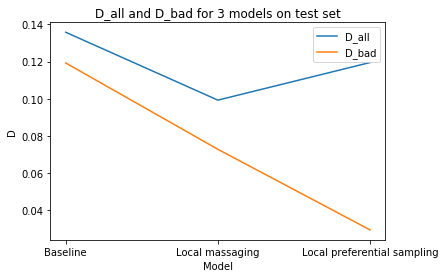

[0.13573754620665374, 0.09924529132195037, 0.11945715462632062]
[0.11922600741704245, 0.07281751731787592, 0.02948165449549718]


In [79]:


# Calculate D_all and D_bad for each model on the test set
D_all_test = [D_all_1,D_all_2,D_all_3]
D_bad_test = [D_bad_1, D_bad_2, D_bad_3]

plt.plot(['Baseline', 'Local massaging', 'Local preferential sampling'], D_all_test, label='D_all')
plt.plot(['Baseline', 'Local massaging', 'Local preferential sampling'], D_bad_test, label='D_bad')

# Add axis labels and title
plt.xlabel('Model')
plt.ylabel('D')
plt.title('D_all and D_bad for 3 models on test set')

# Add legend
plt.legend()

# Show the plot
plt.show()


print(D_all_test)
print(D_bad_test)

From the plot, we can see that the two algorithms both achieves the original goal of reducing bad discrimination. We can also see that the Local preferential sampling algorithm reduces bad discrimination more, which is a better choice in this dataset.

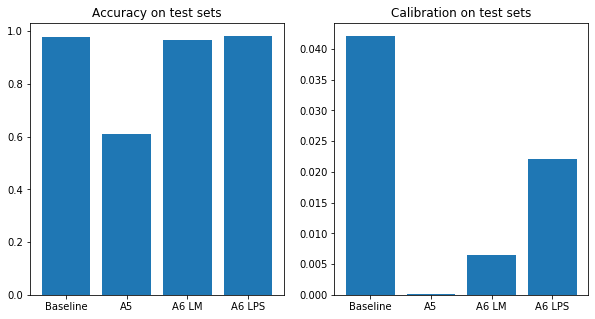

In [96]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define function to compute calibration
def compute_calibration(df):
    african_american = df[df['race'] == 'African-American']
    caucasian = df[df['race'] == 'Caucasian']
    african_american_accuracy = accuracy_score(african_american['two_year_recid'], african_american['y_pred'])
    caucasian_accuracy = accuracy_score(caucasian['two_year_recid'], caucasian['y_pred'])
    return abs(african_american_accuracy - caucasian_accuracy)

# Compute accuracy and calibration for test set 1
accuracy_test1 = accuracy_score(test_df1['two_year_recid'], test_df1['y_pred'])
calibration_test1 = compute_calibration(test_df1)
baseline_cal=calibration_test1*len((e.unique()))

# Compute accuracy and calibration for test set 2
accuracy_test2 = accuracy_score(test_df2['two_year_recid'], test_df2['y_pred'])
calibration_test2 = compute_calibration(test_df2)

# Compute accuracy and calibration for test set 3
accuracy_test3 = accuracy_score(test_df3['two_year_recid'], test_df3['y_pred'])
calibration_test3 = compute_calibration(test_df3)

A5_acc=0.61
A5_calibration=0.00016

# Plot results
accuracies = [accuracy_test1,A5_acc, accuracy_test2, accuracy_test3]
calibrations = [baseline_cal, A5_calibration,calibration_test2, calibration_test3]



models = ['Baseline', 'A5', 'A6 LM','A6 LPS']
accs = accuracies
cals = calibrations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].bar(models, accuracies)
axs[0].set_title('Accuracy on test sets')
axs[1].bar(models, calibrations)
axs[1].set_title('Calibration on test sets')
plt.show()








We can see that both two algorithms reduces the calibration. A5 reduces calibration to nearly 0, but it sacrifices accuracy too much. A6 LM does a good job in accuracy and calibration trade-off for it remains high accuracy and reduces calibration.